# Proyek Klasifikasi Gambar: Flower Recognition

## Import Semua Packages/Library yang Digunakan

In [3]:
import tensorflow as tf
import numpy as np
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from google.colab import files

## Data Preparation

### Data Loading

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilasalsabila","key":"4030d9364a948953268ff33e3ff58d8a"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
100% 225M/225M [00:10<00:00, 24.9MB/s]
100% 225M/225M [00:10<00:00, 21.7MB/s]


In [6]:
with zipfile.ZipFile('flowers-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset_flowers')

In [7]:
train_dir = '/content/dataset_flowers/flowers'

## Data Preprocessing

### Split Dataset

In [27]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


## Modelling

In [29]:
class StopAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.85, target_val_accuracy=0.85):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= self.target_accuracy and val_accuracy >= self.target_val_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy and {self.target_val_accuracy * 100}% val accuracy, stop training!")
            self.model.stop_training = True

In [30]:
checkpoint = ModelCheckpoint('best_flower_model.keras', monitor='val_accuracy', save_best_only=True)
stop_at_85_callback = StopAtAccuracy(target_accuracy=0.85, target_val_accuracy=0.85)

In [31]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(
    train_generator,
    epochs=80,
    validation_data=validation_generator,
    callbacks=[checkpoint, stop_at_85_callback]
)

Epoch 1/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.3670 - loss: 1.4973 - val_accuracy: 0.6326 - val_loss: 0.9618
Epoch 2/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 309ms/step - accuracy: 0.6501 - loss: 0.9310 - val_accuracy: 0.7395 - val_loss: 0.6975
Epoch 3/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 34s 301ms/step - accuracy: 0.7378 - loss: 0.7284 - val_accuracy: 0.7372 - val_loss: 0.7446
Epoch 4/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 288ms/step - accuracy: 0.7616 - loss: 0.6723 - val_accuracy: 0.6547 - val_loss: 0.9834
Epoch 5/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.7648 - loss: 0.6364 - val_accuracy: 0.7860 - val_loss: 0.5651
Epoch 6/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 35s 287ms/step - accuracy: 0.7668 - loss: 0.6180 - val_accuracy: 0.7860 - val_loss: 0.5738
Epoch 7/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.8081 - loss: 0.5140 - val_accuracy: 0.6802 - val_loss: 0.8525
Epoch 8/80
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 393ms/step - accuracy: 0.8067 - loss: 0

## Evaluasi dan Visualisasi

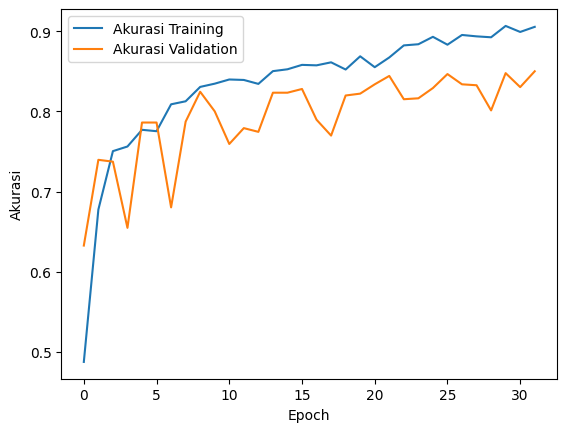

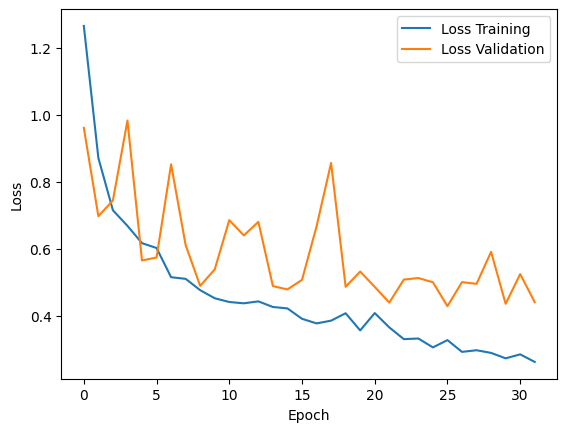

In [35]:
import matplotlib.pyplot as plt
# Plot akurasi dan loss
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [36]:
# SavedModel
save_path = 'flower_recognition_model'
tf.saved_model.save(model, save_path)

In [37]:
# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('flower_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpj_aw85wu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_93')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138150214948240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214950704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214947536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214956160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214956688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214950880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214945600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150214948592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150476810720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150476820928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13815047681

In [38]:
# Convert ke TFJS
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 106.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [39]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

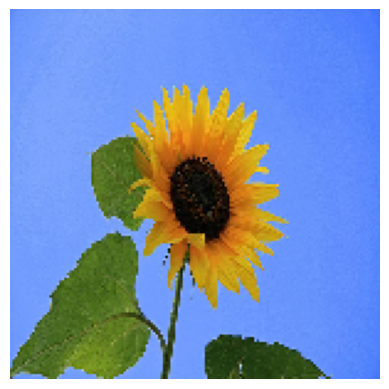

Prediksi: sunflower


In [42]:
# Inference menggunakan TF-Lite
def predict_tflite_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    interpreter = tf.lite.Interpreter(model_path='flower_recognition_model.tflite')
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Membuat prediksi
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    classes = list(train_generator.class_indices.keys())
    print("Prediksi:", classes[np.argmax(prediction)])

# Test
predict_tflite_image('/content/dataset_flowers/flowers/sunflower/1044296388_912143e1d4.jpg')

In [43]:
!pip freeze > requirements.txt